In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.interpolate import CubicSpline
from itertools import product
from sklearn.metrics import r2_score
import csv
from vmd import VMD
from scipy import stats

In [89]:
# adjusted R-squared
def r2_score_adjusted(y, y_pred, featurecount):
    n = len(y)
    return 1 - (1-r2_score(y, y_pred)) * (n-1)/(n-featurecount-1)

# AIC
def calculate_aic(y, y_pred, k):
    sse = np.sum((y - y_pred) ** 2)
    n = len(y)
    aic = n * np.log(sse / n) + 2 * k
    return aic

# BIC
def calculate_bic(y, y_pred, k):
    sse = np.sum((y - y_pred) ** 2)
    n = len(y)
    bic = n * np.log(sse / n) + k * np.log(n)
    return bic

# Хи 2
def chi_square_test(series1, series2, bins=10, alpha=0.05):
    """
    Вычисление критерия Хи-квадрат об однородности выборок для двух временных рядов
    
    Параметры:
    series1 (array-like): Первый временной ряд
    series2 (array-like): Второй временной ряд
    bins (int): Количество интервалов для разбиения данных
    alpha (float): Уровень значимости
    
    Возвращает:
    dict: Словарь с результатами теста
    """
    # Преобразуем входные данные в numpy массивы
    series1 = np.array(series1)
    series2 = np.array(series2)

    # Проверяем, что ряды имеют одинаковую длину
    if len(series1) != len(series2):
        raise ValueError("Временные ряды должны иметь одинаковую длину")
    
    # Объединяем данные для определения общих границ интервалов
    combined_data = np.concatenate([series1, series2])
    
    # Определяем границы интервалов на основе объединенных данных
    bin_edges = np.linspace(np.min(combined_data), np.max(combined_data), bins + 1)
    
    # Вычисляем частоты для каждого ряда
    hist1, _ = np.histogram(series1, bins=bin_edges)
    hist2, _ = np.histogram(series2, bins=bin_edges)
    
    # Убираем нулевые частоты, чтобы избежать деления на ноль
    valid_indices = (hist1 > 0) & (hist2 > 0)
    hist1 = hist1[valid_indices]
    hist2 = hist2[valid_indices]
    
    # Если после фильтрации не осталось данных, возвращаем ошибку
    if len(hist1) == 0 or len(hist2) == 0:
        raise ValueError("После фильтрации нулевых частот не осталось данных для анализа")
    
    # Создаем таблицу сопряженности (contingency table)
    contingency_table = np.vstack([hist1, hist2])
    
    # Проверяем, что в каждой ячейке ожидаемая частота не менее 5
    # (требование для корректного применения критерия хи-квадрат)
    row_sums = contingency_table.sum(axis=1, keepdims=True)
    col_sums = contingency_table.sum(axis=0, keepdims=True)
    n = contingency_table.sum()
    expected = np.dot(row_sums, col_sums) / n
    
    # Проверка условия применимости критерия
    min_expected = np.min(expected)
    valid_test = min_expected >= 5
    
    # Вычисляем статистику хи-квадрат и p-значение
    chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    
    # Критическое значение для заданного уровня значимости
    critical_value = stats.chi2.ppf(1 - alpha, dof)
    
    # Принятие решения
    reject_h0 = p_value < alpha
    
    return {
        'chi2_stat': chi2_stat,
        'p_value': p_value,
        'dof': dof,
        'critical_value': critical_value,
        'reject_h0': reject_h0,
        'contingency_table': contingency_table,
        'expected': expected,
        'bin_edges': bin_edges,
        'min_expected': min_expected,
        'valid_test': valid_test,
        'alpha': alpha
    }

# импорт временного ряда

In [90]:
index = list()
TS = list()
Trend = list()

s = pd.read_csv(f".\Components\\s10.csv", decimal=',')
n = pd.read_csv(f".\Components\\n1.csv", decimal=',')
Season = pd.DataFrame(s, dtype=float)
Season = Season["Value"]
Noise = pd.DataFrame(n, dtype=float)
Noise = Noise["Value"]

for i in range(1,8):
    data = pd.read_csv(f".\Cases\\t{i}_n1_s10.csv", decimal=',')
    t = pd.read_csv(f".\Components\\t{i}.csv", decimal=',')

    df = pd.DataFrame(data, dtype=float)
    trend = pd.DataFrame(t, dtype=float)

    index.append(df.index)
    TS.append(df.values) 
    Trend.append(trend["Value"])

# тестовый анализ

In [98]:
alpha = 10
init = 1
DC = True
K = 3
tau = 0            #BY DEFAULT  
tol = 1e-6         #BY DEFAULT

u, u_hat, omega = VMD(TS[0], alpha, tau, K, DC, init, tol)

featurecount = 6

Text(0.5, 0, 'X')

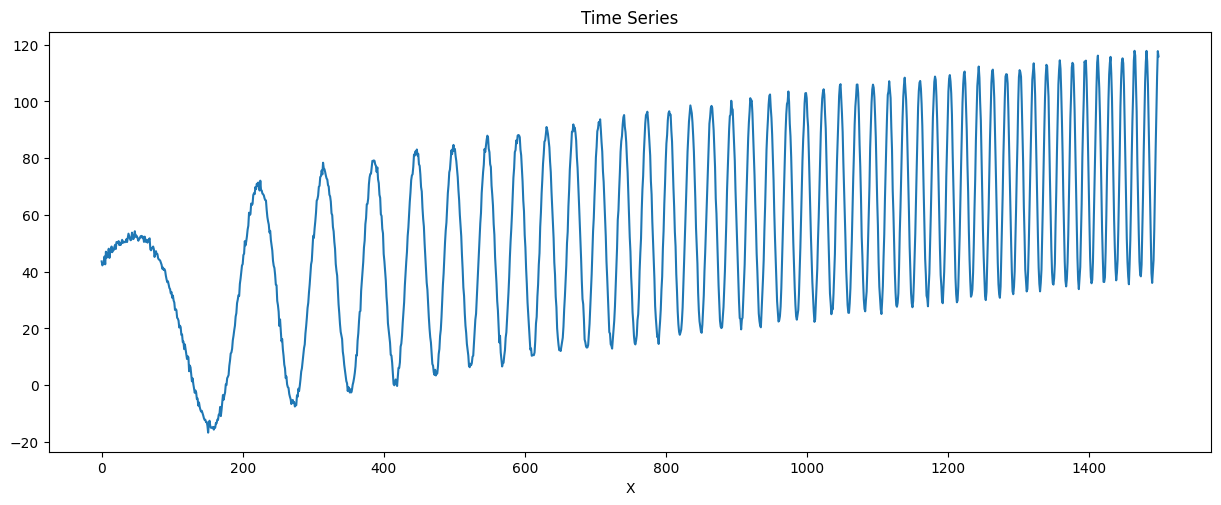

In [99]:
plt.figure(figsize=(15,12))
plt.subplot(2,1,1)
plt.plot(index[0], TS[0])
plt.title('Time Series')
plt.xlabel('X')

Text(0.5, 0, 'X')

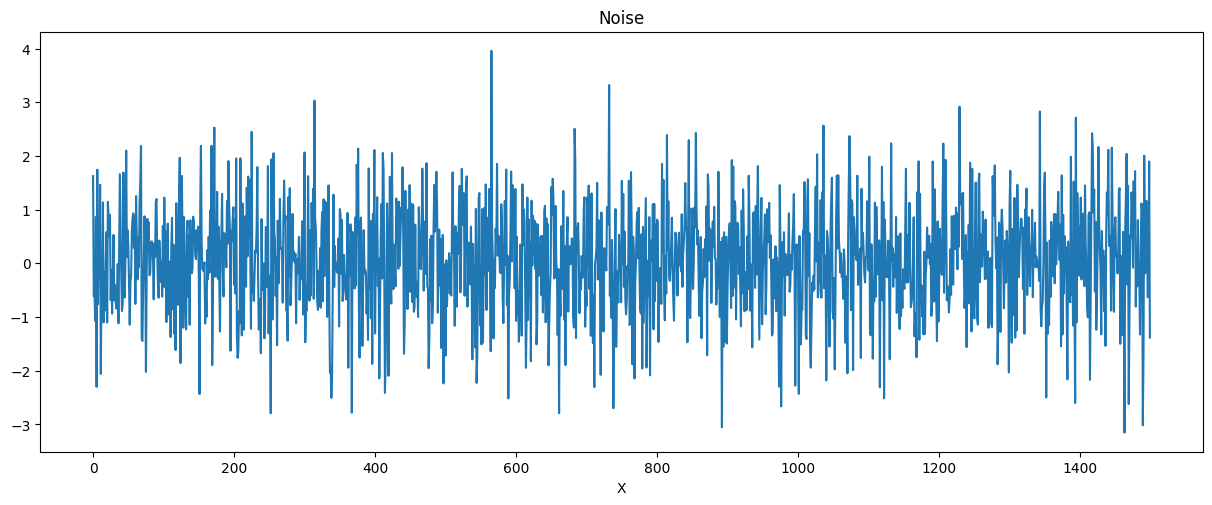

In [100]:
plt.figure(figsize=(15,12))
plt.subplot(2,1,1)
plt.plot(index[0], Noise)
plt.title('Noise')
plt.xlabel('X')

In [101]:
f = TS[0][::].reshape((1500,))

noise_imfs = 0
i_imfs = K
for j in range(i_imfs):
    f = f - u[j].T

Text(0.5, 0, 'X')

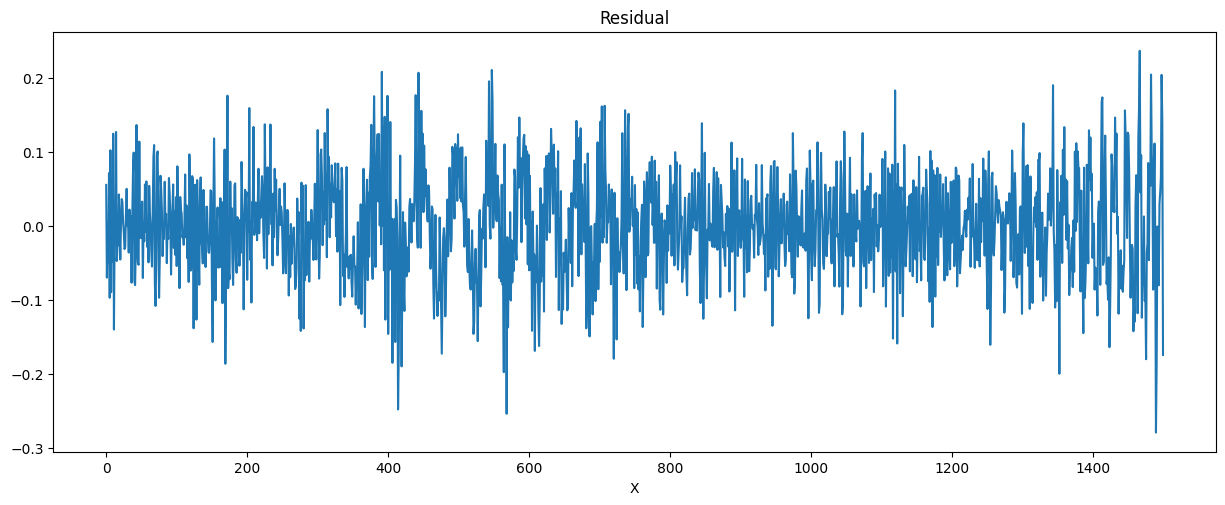

In [102]:
plt.figure(figsize=(15,12))
plt.subplot(2,1,1)
plt.plot(index[0], f)
plt.title('Residual')
plt.xlabel('X')

In [103]:
Noise

0       1.624345
1      -0.611756
2      -0.528172
3      -1.072969
4       0.865408
          ...   
1495    0.196645
1496   -0.632590
1497   -0.209847
1498    1.897161
1499   -1.381391
Name: Value, Length: 1500, dtype: float64

In [105]:
chi_square_test(Noise, f, bins=200)

{'chi2_stat': np.float64(559.691751912557),
 'p_value': np.float64(1.986275454810637e-110),
 'dof': 14,
 'critical_value': np.float64(23.684791304840576),
 'reject_h0': np.True_,
 'contingency_table': array([[ 17,  25,  34,  19,  24,  16,  19,  21,  23,  22,  22,  23,  21,
          18,  15],
        [  1,   2,  12,  27,  78, 150, 273, 316, 279, 201,  93,  44,  16,
           7,   1]]),
 'expected': array([[  3.15667949,   4.73501924,   8.06706982,   8.06706982,
          17.88785047,  29.11159978,  51.20835624,  59.10005498,
          52.96206707,  39.10775151,  20.16767455,  11.74986256,
           6.48873007,   4.38427708,   2.80593733],
        [ 14.84332051,  22.26498076,  37.93293018,  37.93293018,
          84.11214953, 136.88840022, 240.79164376, 277.89994502,
         249.03793293, 183.89224849,  94.83232545,  55.25013744,
          30.51126993,  20.61572292,  13.19406267]]),
 'bin_edges': array([-3.15335745, -3.11779765, -3.08223785, -3.04667805, -3.01111825,
        -2.97555

In [106]:
r2_score(Noise, f)

0.07925103682242507

Text(0.5, 0, 'X')

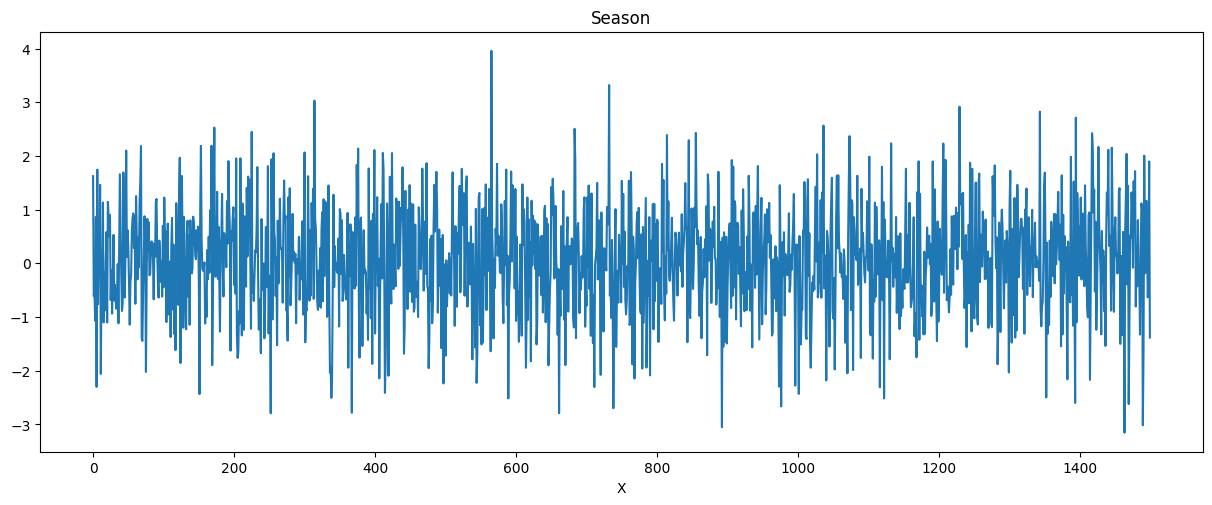

In [107]:
plt.figure(figsize=(15,12))
plt.subplot(2,1,1)
plt.plot(index[0], Noise)
plt.title('Season')
plt.xlabel('X')

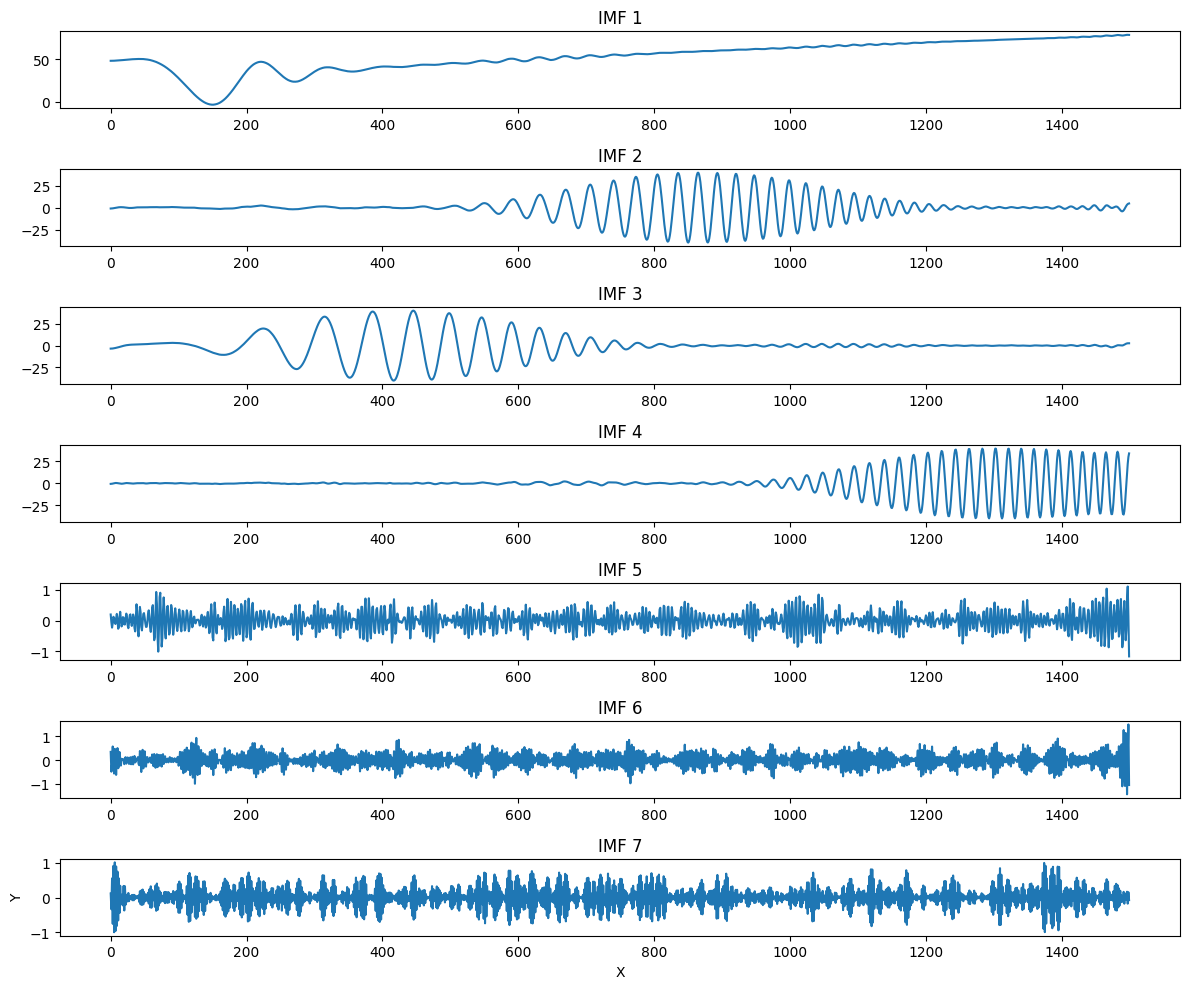

In [101]:
# plt.figure(figsize=(15,12))
# plt.subplot(2,1,1)
# plt.plot(index[0], TS[0])

fig, axs = plt.subplots(figsize=(12,10), nrows=K)

# axs[0].set(xlabel = 'date', ylabel='C')
# plt.subplot(2,2,1)
for i in range(K):
    axs[i].plot(index[0], u[i].T)
    axs[i].set_title(f'IMF {i+1}')

plt.xlabel('X')
plt.ylabel('Y')
# plt.legend(['Оригинальный сигнал', 'Нижняя огибающая', 'Верхняя огибающая', 'Средняя огибающих'])

plt.tight_layout()

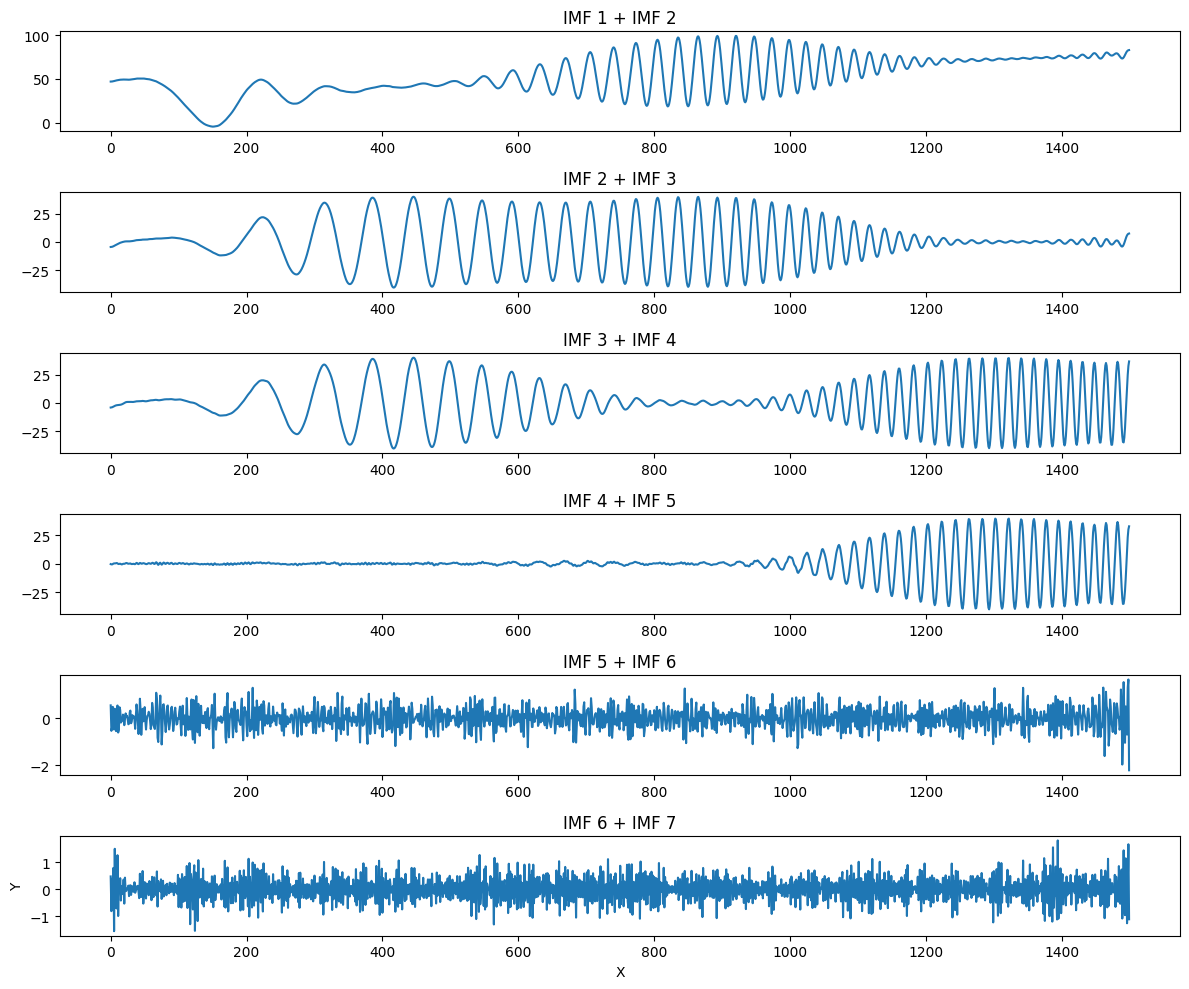

In [102]:
# plt.figure(figsize=(15,12))
# plt.subplot(2,1,1)
# plt.plot(index[0], TS[0])

fig, axs = plt.subplots(figsize=(12,10), nrows=K-1)

# axs[0].set(xlabel = 'date', ylabel='C')
# plt.subplot(2,2,1)
for i in range((K-1)):
    axs[i].plot(index[0], u[i].T + u[i+1].T)
    axs[i].set_title(f'IMF {i+1} + IMF {i+2}')

# plt.title('IMF')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend(['Оригинальный сигнал', 'Нижняя огибающая', 'Верхняя огибающая', 'Средняя огибающих'])

plt.tight_layout()

# декомпозиция временного ряда

In [ ]:
alpha = (0, 500, 1000, 5000, 10000, 20000)
init = (0, 1, 2)
DC = (False, True)
K = (3, 5, 7)

tau = 0            #BY DEFAULT  
tol = 1e-6         #BY DEFAULT

featurecount = 6
bins=200

In [ ]:
best_metriks = list()

best_r2_params = list()
best_r2_adj_params = list()
best_aic_params = list()
best_bic_params = list()
best_chi2_params = list()

# для всех лчм
for ts_i in range(len(TS)):
    best_metriks.append({"Time Series": f"TS{ts_i+1}", "R2": -np.inf, "R2_Adj": -np.inf, "AIC" : np.inf, "BIC": np.inf, "Chi2" : np.inf , "Chi2 limit value" : np.inf})

    best_r2_params.append({"Time Series": f"TS{ts_i+1}", "Metric": "R2", "alpha": 0, "tau": tau, "K": 3, "DC": False, "init": 0, "tol": tol, "Noise IMFs": "3"}) 
    best_r2_adj_params.append({"Time Series": f"TS{ts_i+1}", "Metric": "R2_Adj", "alpha": 0, "tau": tau, "K": 3, "DC": False, "init": 0, "tol": tol, "Noise IMFs": "3"}) 
    best_aic_params.append({"Time Series": f"TS{ts_i+1}", "Metric": "AIC", "alpha": 0, "tau": tau, "K": 3, "DC": False, "init": 0, "tol": tol, "Noise IMFs": "3"}) 
    best_bic_params.append({"Time Series": f"TS{ts_i+1}", "Metric": "BIC", "alpha": 0, "tau": tau, "K": 3, "DC": False, "init": 0, "tol": tol, "Noise IMFs": "3"}) 
    best_chi2_params.append({"Time Series": f"TS{ts_i+1}", "Metric": "Chi2", "alpha": 0, "tau": tau, "K": 3, "DC": False, "init": 0, "tol": tol, "Noise IMFs": "3"}) 

    # для всех наборов параметров
    for params_set in list(product(alpha, K, DC, init)):
        u, u_hat, omega = VMD(TS[ts_i], params_set[0], tau, params_set[1], params_set[2], params_set[3], tol)
        # best_params = [{"Time Series": f"t{ts_i+1}" ,"alpha": params_set[0], "tau": tau, "K": params_set[1], "DC": params_set[2], "init": params_set[3], "tol": tol}]
        
        k_i = params_set[1]
        for i_imfs in range(k_i-2, k_i):

            sum_of_imfs = 0
            for j in range(i_imfs, k_i):
                sum_of_imfs += u[j].T

            r2 = r2_score(Noise, sum_of_imfs)
            r2_adj = r2_score_adjusted(Noise, sum_of_imfs, featurecount)
            aic = calculate_aic(Noise, sum_of_imfs, featurecount)
            bic = calculate_bic(Noise, sum_of_imfs, featurecount)
            chi2 = chi_square_test(Noise, sum_of_imfs, bins=bins)

            if (r2 > best_metriks[ts_i]["R2"]):
                best_metriks[ts_i]["R2"] = r2

                best_r2_params[ts_i]["alpha"] = params_set[0]
                best_r2_params[ts_i]["K"] = params_set[1]
                best_r2_params[ts_i]["DC"] = params_set[2]
                best_r2_params[ts_i]["init"] = params_set[3]
                best_r2_params[ts_i]["Noise IMFs"] = f'{k_i-2} - {i_imfs+1}'

            if (r2_adj > best_metriks[ts_i]["R2_Adj"]):
                best_metriks[ts_i]["R2_Adj"] = r2_adj

                best_r2_adj_params[ts_i]["alpha"] = params_set[0]
                best_r2_adj_params[ts_i]["K"] = params_set[1]
                best_r2_adj_params[ts_i]["DC"] = params_set[2]
                best_r2_adj_params[ts_i]["init"] = params_set[3]
                best_r2_adj_params[ts_i]["Noise IMFs"] = f'{k_i-2} - {i_imfs+1}'


            if (aic < best_metriks[ts_i]["AIC"]):
                best_metriks[ts_i]["AIC"] = aic

                best_aic_params[ts_i]["alpha"] = params_set[0]
                best_aic_params[ts_i]["K"] = params_set[1]
                best_aic_params[ts_i]["DC"] = params_set[2]
                best_aic_params[ts_i]["init"] = params_set[3]
                best_aic_params[ts_i]["Noise IMFs"] = f'{k_i-2} - {i_imfs+1}'

            if (bic < best_metriks[ts_i]["BIC"]):
                best_metriks[ts_i]["BIC"] = bic

                best_bic_params[ts_i]["alpha"] = params_set[0]
                best_bic_params[ts_i]["K"] = params_set[1]
                best_bic_params[ts_i]["DC"] = params_set[2]
                best_bic_params[ts_i]["init"] = params_set[3]
                best_bic_params[ts_i]["Noise IMFs"] = f'{k_i-2} - {i_imfs+1}'

            if (chi2['chi2_stat'] < best_metriks[ts_i]["Chi2"]):
                best_metriks[ts_i]["Chi2"] = chi2['chi2_stat']
                best_metriks[ts_i]["Chi2 critical value"] = chi2['critical_value']

                best_chi2_params[ts_i]["alpha"] = params_set[0]
                best_chi2_params[ts_i]["K"] = params_set[1]
                best_chi2_params[ts_i]["DC"] = params_set[2]
                best_chi2_params[ts_i]["init"] = params_set[3]
                best_chi2_params[ts_i]["Noise IMFs"] = f'{k_i-2} - {i_imfs+1}'


c:\Users\George\VS Code Projects\TS Generator\про лчм\vmd.py:67: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(freqs[T//2:T],(abs(u_hat_plus[n+1, T//2:T, k])**2))/np.sum(abs(u_hat_plus[n+1,T//2:T,k])**2)
c:\Users\George\VS Code Projects\TS Generator\про лчм\vmd.py:64: RuntimeWarning: invalid value encountered in divide
  return (f_hat_plus - sum_uk - lambda_hat[n,:]/2)/(1.+Alpha[k]*(freqs - omega_plus[n,k])**2)
c:\Users\George\VS Code Projects\TS Generator\про лчм\vmd.py:67: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(freqs[T//2:T],(abs(u_hat_plus[n+1, T//2:T, k])**2))/np.sum(abs(u_hat_plus[n+1,T//2:T,k])**2)
c:\Users\George\VS Code Projects\TS Generator\про лчм\vmd.py:64: RuntimeWarning: invalid value encountered in divide
  return (f_hat_plus - sum_uk - lambda_hat[n,:]/2)/(1.+Alpha[k]*(freqs - omega_plus[n,k])**2)
c:\Users\George\VS Code Projects\TS Generator\про лчм\vmd.py:67: RuntimeWarning: invalid value encountered in sc

In [ ]:
for ts_i in range(len(TS)):
    # для всех наборов параметров
    for params_set in list(product(alpha, K, DC, init)):
        u, u_hat, omega = VMD(TS[ts_i], params_set[0], tau, params_set[1], params_set[2], params_set[3], tol)
        # best_params = [{"Time Series": f"t{ts_i+1}" ,"alpha": params_set[0], "tau": tau, "K": params_set[1], "DC": params_set[2], "init": params_set[3], "tol": tol}]
        
        k_i = params_set[1]
        for i_imfs in range(k_i):

            sum_of_imfs = 0
            for j in range(i_imfs+1):
                sum_of_imfs += u[j].T
            residual = TS[ts_i].T[0] - sum_of_imfs

            r2 = r2_score(Noise, residual)
            r2_adj = r2_score_adjusted(Noise, residual, featurecount)
            aic = calculate_aic(Noise, residual, featurecount)
            bic = calculate_bic(Noise, residual, featurecount)
            chi2 = chi_square_test_timeseries(Noise, residual, bins=bins)

            if (r2 > best_metriks[ts_i]["R2"]):
                best_metriks[ts_i]["R2"] = r2

                best_r2_params[ts_i]["alpha"] = params_set[0]
                best_r2_params[ts_i]["K"] = params_set[1]
                best_r2_params[ts_i]["DC"] = params_set[2]
                best_r2_params[ts_i]["init"] = params_set[3]
                best_r2_params[ts_i]["Noise IMFs"] = f'F(t) - IMFs[1-{i_imfs+1}]'

            if (r2_adj > best_metriks[ts_i]["R2_Adj"]):
                best_metriks[ts_i]["R2_Adj"] = r2_adj

                best_r2_adj_params[ts_i]["alpha"] = params_set[0]
                best_r2_adj_params[ts_i]["K"] = params_set[1]
                best_r2_adj_params[ts_i]["DC"] = params_set[2]
                best_r2_adj_params[ts_i]["init"] = params_set[3]
                best_r2_adj_params[ts_i]["Noise IMFs"] = f'F(t) - IMFs[1-{i_imfs+1}]'


            if (aic < best_metriks[ts_i]["AIC"]):
                best_metriks[ts_i]["AIC"] = aic

                best_aic_params[ts_i]["alpha"] = params_set[0]
                best_aic_params[ts_i]["K"] = params_set[1]
                best_aic_params[ts_i]["DC"] = params_set[2]
                best_aic_params[ts_i]["init"] = params_set[3]
                best_aic_params[ts_i]["Noise IMFs"] = f'F(t) - IMFs[1-{i_imfs+1}]'

            if (bic < best_metriks[ts_i]["BIC"]):
                best_metriks[ts_i]["BIC"] = bic

                best_bic_params[ts_i]["alpha"] = params_set[0]
                best_bic_params[ts_i]["K"] = params_set[1]
                best_bic_params[ts_i]["DC"] = params_set[2]
                best_bic_params[ts_i]["init"] = params_set[3]
                best_bic_params[ts_i]["Noise IMFs"] = f'F(t) - IMFs[1-{i_imfs+1}]'

            if (chi2['chi2_stat'] < best_metriks[ts_i]["Chi2"]):
                best_metriks[ts_i]["Chi2"] = chi2['chi2_stat']

                best_chi2_params[ts_i]["alpha"] = params_set[0]
                best_chi2_params[ts_i]["K"] = params_set[1]
                best_chi2_params[ts_i]["DC"] = params_set[2]
                best_chi2_params[ts_i]["init"] = params_set[3]
                best_chi2_params[ts_i]["Noise IMFs"] = f'{k_i-2} - {i_imfs+1}'

c:\Users\George\VS Code Projects\TS Generator\про лчм\vmd.py:67: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(freqs[T//2:T],(abs(u_hat_plus[n+1, T//2:T, k])**2))/np.sum(abs(u_hat_plus[n+1,T//2:T,k])**2)
c:\Users\George\VS Code Projects\TS Generator\про лчм\vmd.py:64: RuntimeWarning: invalid value encountered in divide
  return (f_hat_plus - sum_uk - lambda_hat[n,:]/2)/(1.+Alpha[k]*(freqs - omega_plus[n,k])**2)
c:\Users\George\VS Code Projects\TS Generator\про лчм\vmd.py:67: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(freqs[T//2:T],(abs(u_hat_plus[n+1, T//2:T, k])**2))/np.sum(abs(u_hat_plus[n+1,T//2:T,k])**2)
c:\Users\George\VS Code Projects\TS Generator\про лчм\vmd.py:64: RuntimeWarning: invalid value encountered in divide
  return (f_hat_plus - sum_uk - lambda_hat[n,:]/2)/(1.+Alpha[k]*(freqs - omega_plus[n,k])**2)
c:\Users\George\VS Code Projects\TS Generator\про лчм\vmd.py:67: RuntimeWarning: invalid value encountered in sc

# метрики точности и параметры с выводом

In [ ]:
filename=".\Output\\Best_Metriks-Noise.csv"

fields = best_metriks[0].keys()
fields = list(fields)

with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()  # Write header row
    for ts_i in range(len(TS)):
        writer.writerows([best_metriks[ts_i]])  # Write data rows

In [ ]:
filename=".\Output\\Parameters-Noise.csv"

fields = best_r2_params[0].keys()
fields = list(fields)

with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()  # Write header row
    for ts_i in range(len(TS)):
        writer.writerows([best_r2_params[ts_i]])  # Write data rows
        writer.writerows([best_r2_adj_params[ts_i]])  # Write data rows
        writer.writerows([best_aic_params[ts_i]])  # Write data rows
        writer.writerows([best_bic_params[ts_i]])  # Write data rows
        writer.writerows([best_chi2_params[ts_i]])  # Write data rows
